In [1]:
import os
os.chdir('../..')

In [2]:
import numpy as np
import torch

from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG

from molexplain.utils import MODELS_PATH, PROCESSED_DATA_PATH

RDKit WARNING: [11:40:05] Enabling RDKit 2019.09.3 jupyter extensions


In [3]:
model = torch.load(os.path.join(MODELS_PATH, "AZ_ChEMBL.pt"))
inchis = np.load(os.path.join(PROCESSED_DATA_PATH, "inchis.npy"))

In [4]:
from rdkit.Chem import MolFromInchi

In [5]:
example_inchi = inchis[396]
print(example_inchi)

InChI=1S/C17H16N4O4/c22-10-4-9-20-15-8-2-1-7-14(15)18-17(20)19-16(23)12-5-3-6-13(11-12)21(24)25/h1-3,5-8,11,22H,4,9-10H2,(H,18,19,23)


In [6]:
mol = MolFromInchi(example_inchi)

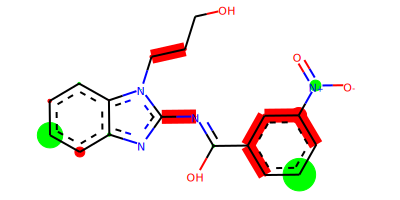

In [7]:
from molexplain.vis import molecule_importance
molecule_importance(mol, model, task=0, vis_factor=5)